In [132]:
from spinncer.analysis_common import *
%matplotlib inline
import traceback
from matplotlib.ticker import FixedLocator

In [915]:
path_to_results = "/localhome/mbax3pb2/SpiNNCer/tests/01_ms_tests/results/" 
baseline = None
file = None

# -------------BASELINE--------------------
baseline = "DC_testing_all_cells_nest_r_mem_False.npz"   # NEST <------------------

# baseline = "DC_testing_all_cells_spinnaker_r_mem_False_RD.npz"
# baseline = "DC_testing_all_cells_spinnaker_r_mem_True_RTN.npz"
# baseline = "DC_testing_all_cells_spinnaker_r_mem_True_RTN.npz"
# baseline = "DC_testing_all_cells_spinnaker_r_mem_False_RD.npz"

# -------------   FILE --------------------
# ------- Vanilla -------
# file = "DC_testing_all_cells_spinnaker_r_mem_False.npz"
file = "DC_testing_all_cells_spinnaker_r_mem_False_RD.npz"
# file = "DC_testing_all_cells_spinnaker_r_mem_False_RTN.npz"
# file = "DC_testing_all_cells_spinnaker_r_mem_False_SR.npz"

# file = "DC_testing_all_cells_spinnaker_r_mem_False_RD_reorder.npz"
# file = "DC_testing_all_cells_spinnaker_r_mem_False_RD_reorder_not_inline.npz"
# file = "DC_testing_all_cells_spinnaker_r_mem_False_RD_S1615.npz"

# baseline = "DC_testing_all_cells_spinnaker_r_mem_False_RD.npz"
# file = "DC_testing_all_cells_spinnaker_r_mem_False_RD_volatile.npz"
# ------- R MEM -------
# file = "DC_testing_all_cells_spinnaker_r_mem_True_RTN.npz"
# file = "DC_testing_all_cells_spinnaker_r_mem_True_RD.npz"

DEFAULT_FIGURE_DIR = 'figures/'
DEFAULT_RESULT_DIR = 'results/'

file_path = os.path.join(path_to_results,file)
baseline_path = os.path.join(path_to_results,baseline)

fig_folder = DEFAULT_FIGURE_DIR
worst_case = True
delay_sensitive=True
dark_background=False
highlight_stim=True

In [916]:
# Baseline values
baseline_data = np.load(baseline_path, allow_pickle=True)
baseline_spikes=baseline_data['spikes'].ravel()[0]
baseline_vs=baseline_data['v'].ravel()[0]
# Experiment parameters
baseline_subcycles=baseline_data['subcycles']
baseline_simtime=baseline_data['simtime']
baseline_dc_currents=baseline_data['spinnaker_dc_currents']
# baseline_spinnaker_dc_currents=baseline_data['spinnaker_dc_currents']

In [917]:
# Baseline values
data = np.load(file_path, allow_pickle=True)
spikes=data['spikes'].ravel()[0]
vs=data['v'].ravel()[0]
# Experiment parameters
subcycles=data['subcycles']
simtime=data['simtime']
dc_currents=data['spinnaker_dc_currents']
# spinnaker_dc_currents=data['spinnaker_dc_currents']

In [918]:
assert np.all(baseline_dc_currents==dc_currents)

In [919]:
assert simtime == baseline_simtime

In [920]:
# https://stackoverflow.com/questions/56654952/how-to-mark-cells-in-matplotlib-pyplot-imshow-drawing-cell-borders
def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x, y), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

def highlight_column(x,y, height, ax=None, **kwargs):
    rect = plt.Rectangle((x, y), 1, height, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

def closest_ioffset_index(value, dc_currents):
    diffs = dc_currents - value
    argmin = np.argmin(np.abs(diffs))
    return argmin

def count_spikes_per_neuron(spikes):
    nids = np.unique(spikes[:, 0]).astype(int)
    spike_counts = np.zeros(np.max(nids)+1)
    for n in nids:
        spike_counts[n] = spikes[spikes[:, 0]==n].size
    return spike_counts

def compute_lead_or_lag_per_neuron(spikes_1, spikes_2, nth_spike):
    nids = np.unique(spikes_1[:, 0]).astype(int)
    spike_lead_lag = np.zeros(np.max(nids)+1)
    for n in nids:
        filtered_spikes_1 = np.sort(spikes_1[spikes_1[:, 0]==n][:, 1])
        filtered_spikes_2 = np.sort(spikes_2[spikes_2[:, 0]==n][:, 1])
        if filtered_spikes_1.size < nth_spike or filtered_spikes_2.size < nth_spike:
            spike_lead_lag[n] = np.nan
        else:
            spike_lead_lag[n] = filtered_spikes_1[nth_spike] - filtered_spikes_2[nth_spike]
    return spike_lead_lag

def plot_imshow_diff_map(diff_map, plot_order, dc_currents, subcycles, xlabel, cmap_label, fig_name, fig_folder, vmax=None):
    camera_ready_dc = ["{:3.2f}".format(x) for x in dc_currents]
    camera_ready_pops = [use_display_name(x) for x in plot_order]
    n_pops = len(plot_order)
    n_sc = len(subcycles)
    n_dc = len(dc_currents)
    
    f = plt.figure(1, figsize=(7, 7), dpi=500)
    im = plt.imshow(diff_map, interpolation='none', vmax=vmax,
                    extent=[0, dc_currents.size, (n_sc) * n_pops, 0],
                    origin='upper')
    ax = plt.gca()

    plt.xlabel(xlabel)
    plt.ylabel("Population")

    plt.xticks(np.arange(dc_currents.size)[::4], camera_ready_dc[::4])
    plt.yticks(np.arange(len(camera_ready_pops))*n_sc + (n_sc/2.) - .5, camera_ready_pops, rotation=90, va='center')
    ax.yaxis.set_minor_locator(FixedLocator(np.arange(len(camera_ready_pops))*n_sc))
    
    plt.grid(b=True, which='minor', color='k', linestyle='-', linewidth=1)
    for p_id, po in enumerate(plot_order):
        closest = closest_used_dc_current[po]
        highlight_column(closest, p_id * n_sc, n_sc, color="white", linewidth=1, zorder=4)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", "5%", pad="3%")
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(cmap_label)

    plt.show()
    save_figure(plt, os.path.join(fig_folder,
                          fig_name),
                extensions=['.png', '.pdf'])
    plt.close(f)

In [921]:
# def plot_rate_diff(spikes, baseline_spikes, subcycles, dc_currents):
plot_order = get_plot_order(spikes[subcycles[0]].keys())
n_pops = len(plot_order)
n_sc = len(subcycles)
n_dc = len(dc_currents)
nth_spike = 10

diff_map = np.ones((n_pops*n_sc, n_dc)) * np.nan
spike_lead_lag_map_10th = np.ones((n_pops*n_sc, n_dc)) * np.nan
spike_lead_lag_map_100th = np.ones((n_pops*n_sc, n_dc)) * np.nan

spike_count_map_baseline = np.ones((n_pops*n_sc, n_dc)) * np.nan
spike_count_map = np.ones((n_pops*n_sc, n_dc)) * np.nan


for sc in subcycles:
    for index, pop in enumerate(plot_order):
        # y position should be dictated by population index and sc 
        comp_spike_count = count_spikes_per_neuron(spikes[sc][pop])
        baseline_spike_count = count_spikes_per_neuron(baseline_spikes[sc][pop])
        diff_map[index*n_sc + (sc-1)] = comp_spike_count - baseline_spike_count    
        spike_count_map_baseline[index*n_sc + (sc-1)] = baseline_spike_count
        spike_count_map[index*n_sc + (sc-1)] = comp_spike_count
        spike_lead_lag_map_10th[index*n_sc + (sc-1)] = compute_lead_or_lag_per_neuron(spikes[sc][pop], baseline_spikes[sc][pop], 10)
        spike_lead_lag_map_100th[index*n_sc + (sc-1)] = compute_lead_or_lag_per_neuron(spikes[sc][pop], baseline_spikes[sc][pop], 100)
        
max_firing_rate = np.max((spike_count_map_baseline, spike_count_map))

In [922]:
print("Min diff", np.min(diff_map))
print("Max diff", np.max(diff_map))
print("Max firing rate", max_firing_rate)

Min diff -4.0
Max diff 584.0
Max firing rate 12282.0


In [923]:
camera_ready_dc = ["{:3.2f}".format(x) for x in dc_currents]
camera_ready_pops = [use_display_name(x) for x in plot_order]

In [924]:
prescribed_ioffsets = {}
for k, v in CELL_PARAMS.items():
    prescribed_ioffsets[k]  = v['i_offset'] if 'i_offset' in v.keys() else 0
closest_used_dc_current = {}
for k, v in prescribed_ioffsets.items():
    diffs = dc_currents - v
    argmin = np.argmin(np.abs(diffs))
    print("Closest dc current used to ", v, "for ", k, " is ", dc_currents[argmin])
    closest_used_dc_current[k] = argmin

Closest dc current used to  0.0 for  granule  is  0.01666259765625
Closest dc current used to  0.0156 for  basket  is  0.01666259765625
Closest dc current used to  0.0156 for  stellate  is  0.01666259765625
Closest dc current used to  0 for  glomerulus  is  0.01666259765625
Closest dc current used to  0.6 for  purkinje  is  0.600006103515625
Closest dc current used to  0.0368 for  golgi  is  0.0333251953125
Closest dc current used to  0.0558 for  dcn  is  0.04998779296875


In [925]:
prescribed_ioffsets

{'basket': 0.0156,
 'dcn': 0.0558,
 'glomerulus': 0,
 'golgi': 0.0368,
 'granule': 0.0,
 'purkinje': 0.6,
 'stellate': 0.0156}

# What is the difference in spike counts (time is 1 second, so equivalent to firing rates) between SpiNNaker and NEST?

The values are computed for each neuron and subcycle pair as $F_{SpiNNaker}-F_{NEST}$. The results below show that SpiNNaker either matches or produces more spikes than NEST; it never underestimates the number of spikes produced in any of the cases.

A single sub-cycle (default value for the solver) produces most accurate results in all cases here. Could this be a side effect of RD?

RD and RTN produce identical number of spikes. The question is now whether the differ in terms of lead/lag of spikes. 

After testing, they do not produce different lead or lag, so the results seem identical.

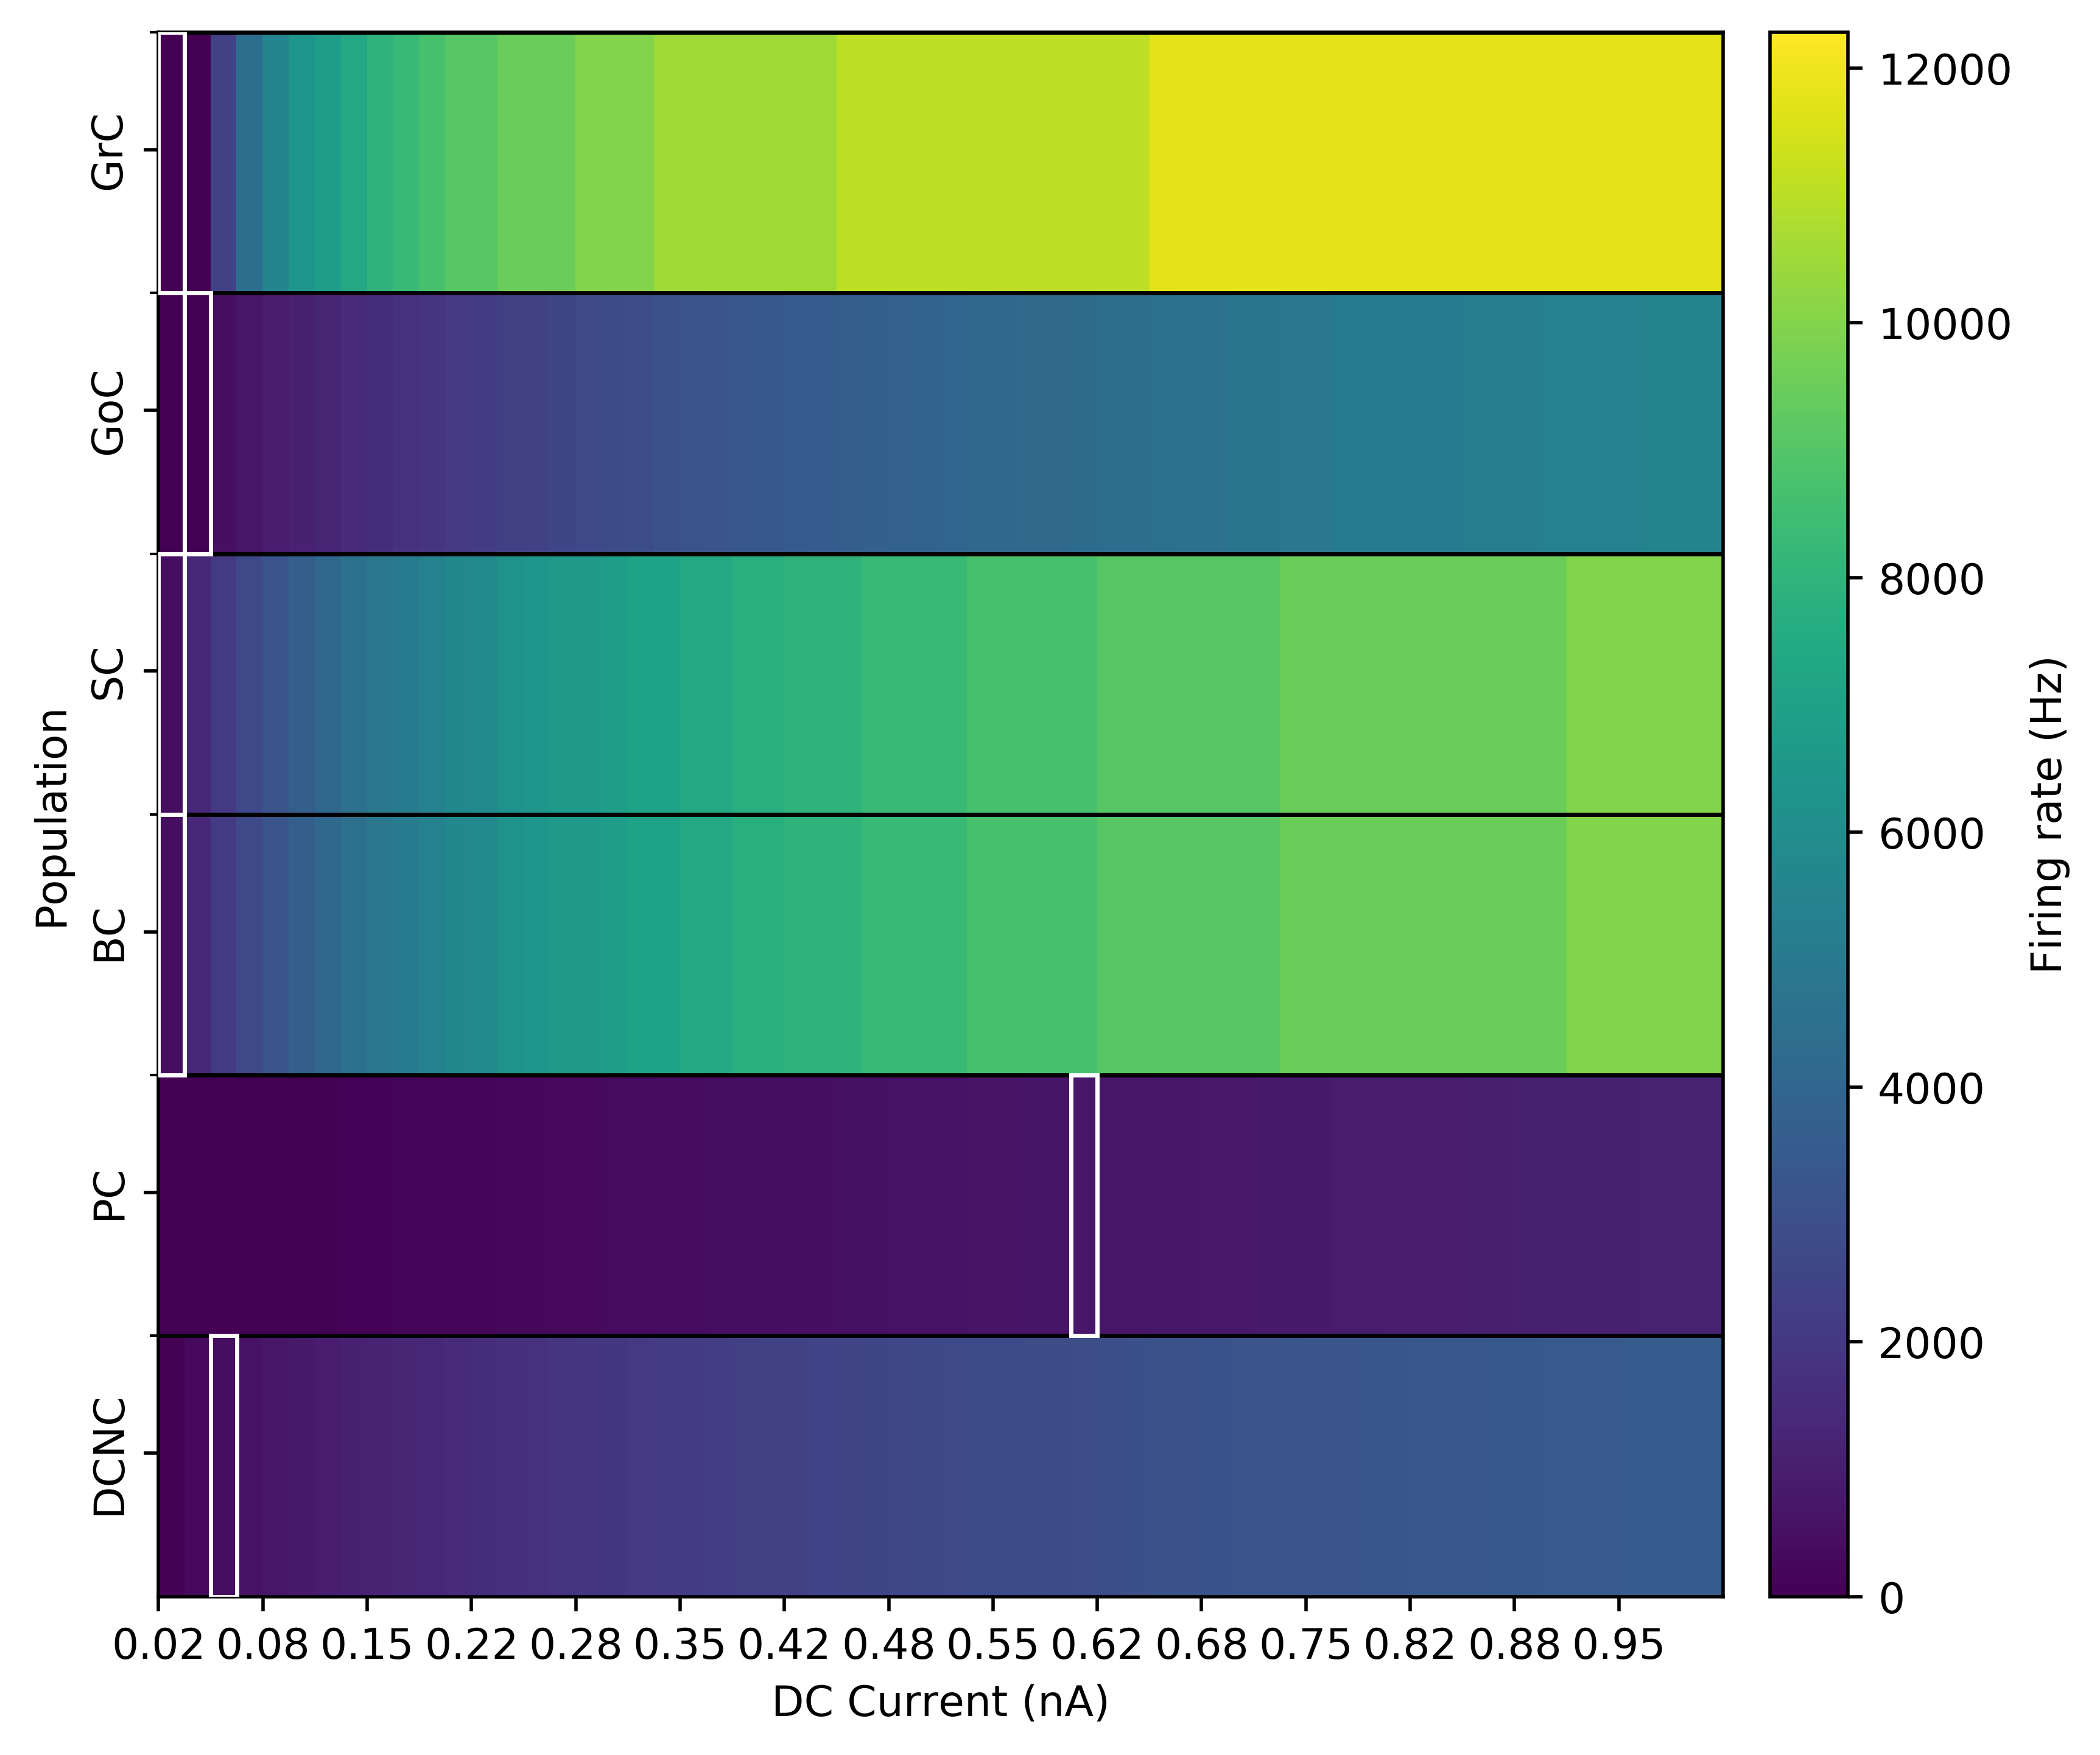

Plotting                                :figures/baseline_firing_rate_map.png   
Plotting                                :figures/baseline_firing_rate_map.pdf   


<Figure size 432x288 with 0 Axes>

In [926]:
plot_imshow_diff_map(spike_count_map_baseline, plot_order, dc_currents, subcycles, "DC Current (nA)", "Firing rate (Hz)", "baseline_firing_rate_map", fig_folder, vmax=max_firing_rate)

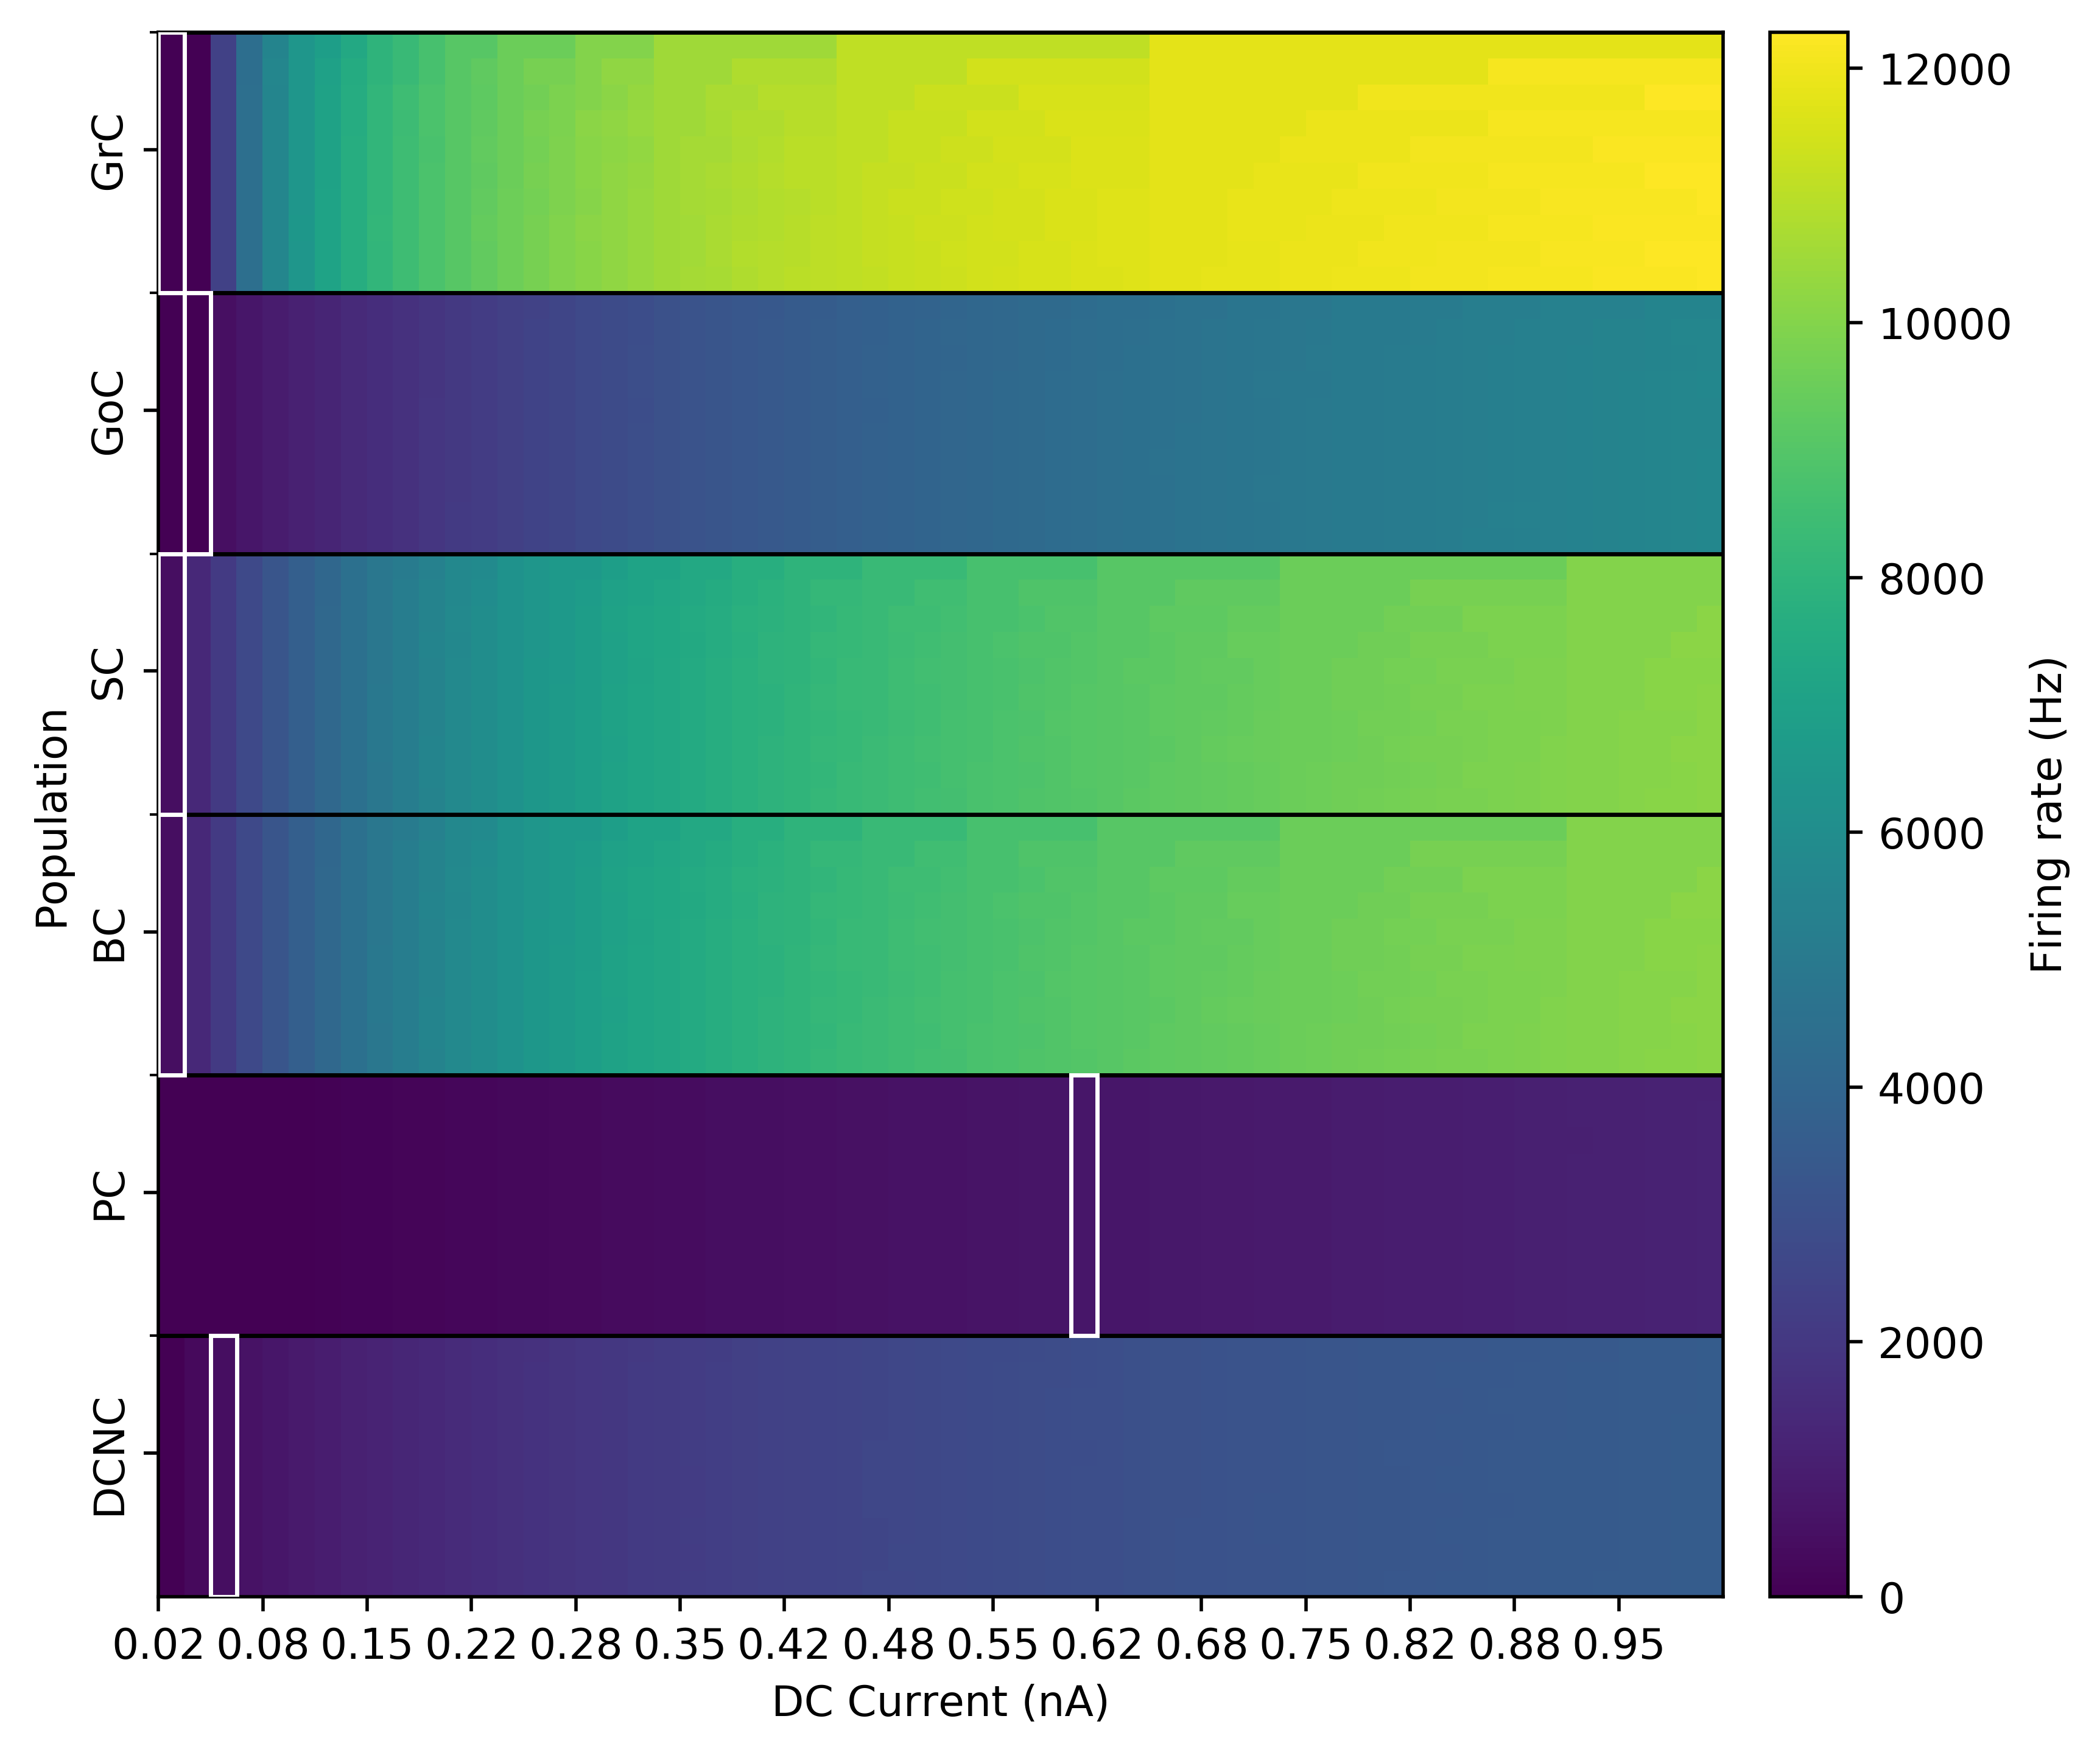

Plotting                                :figures/firing_rate_map.png            
Plotting                                :figures/firing_rate_map.pdf            


<Figure size 432x288 with 0 Axes>

In [927]:
plot_imshow_diff_map(spike_count_map, plot_order, dc_currents, subcycles, "DC Current (nA)", "Firing rate (Hz)", "firing_rate_map", fig_folder, vmax=max_firing_rate)

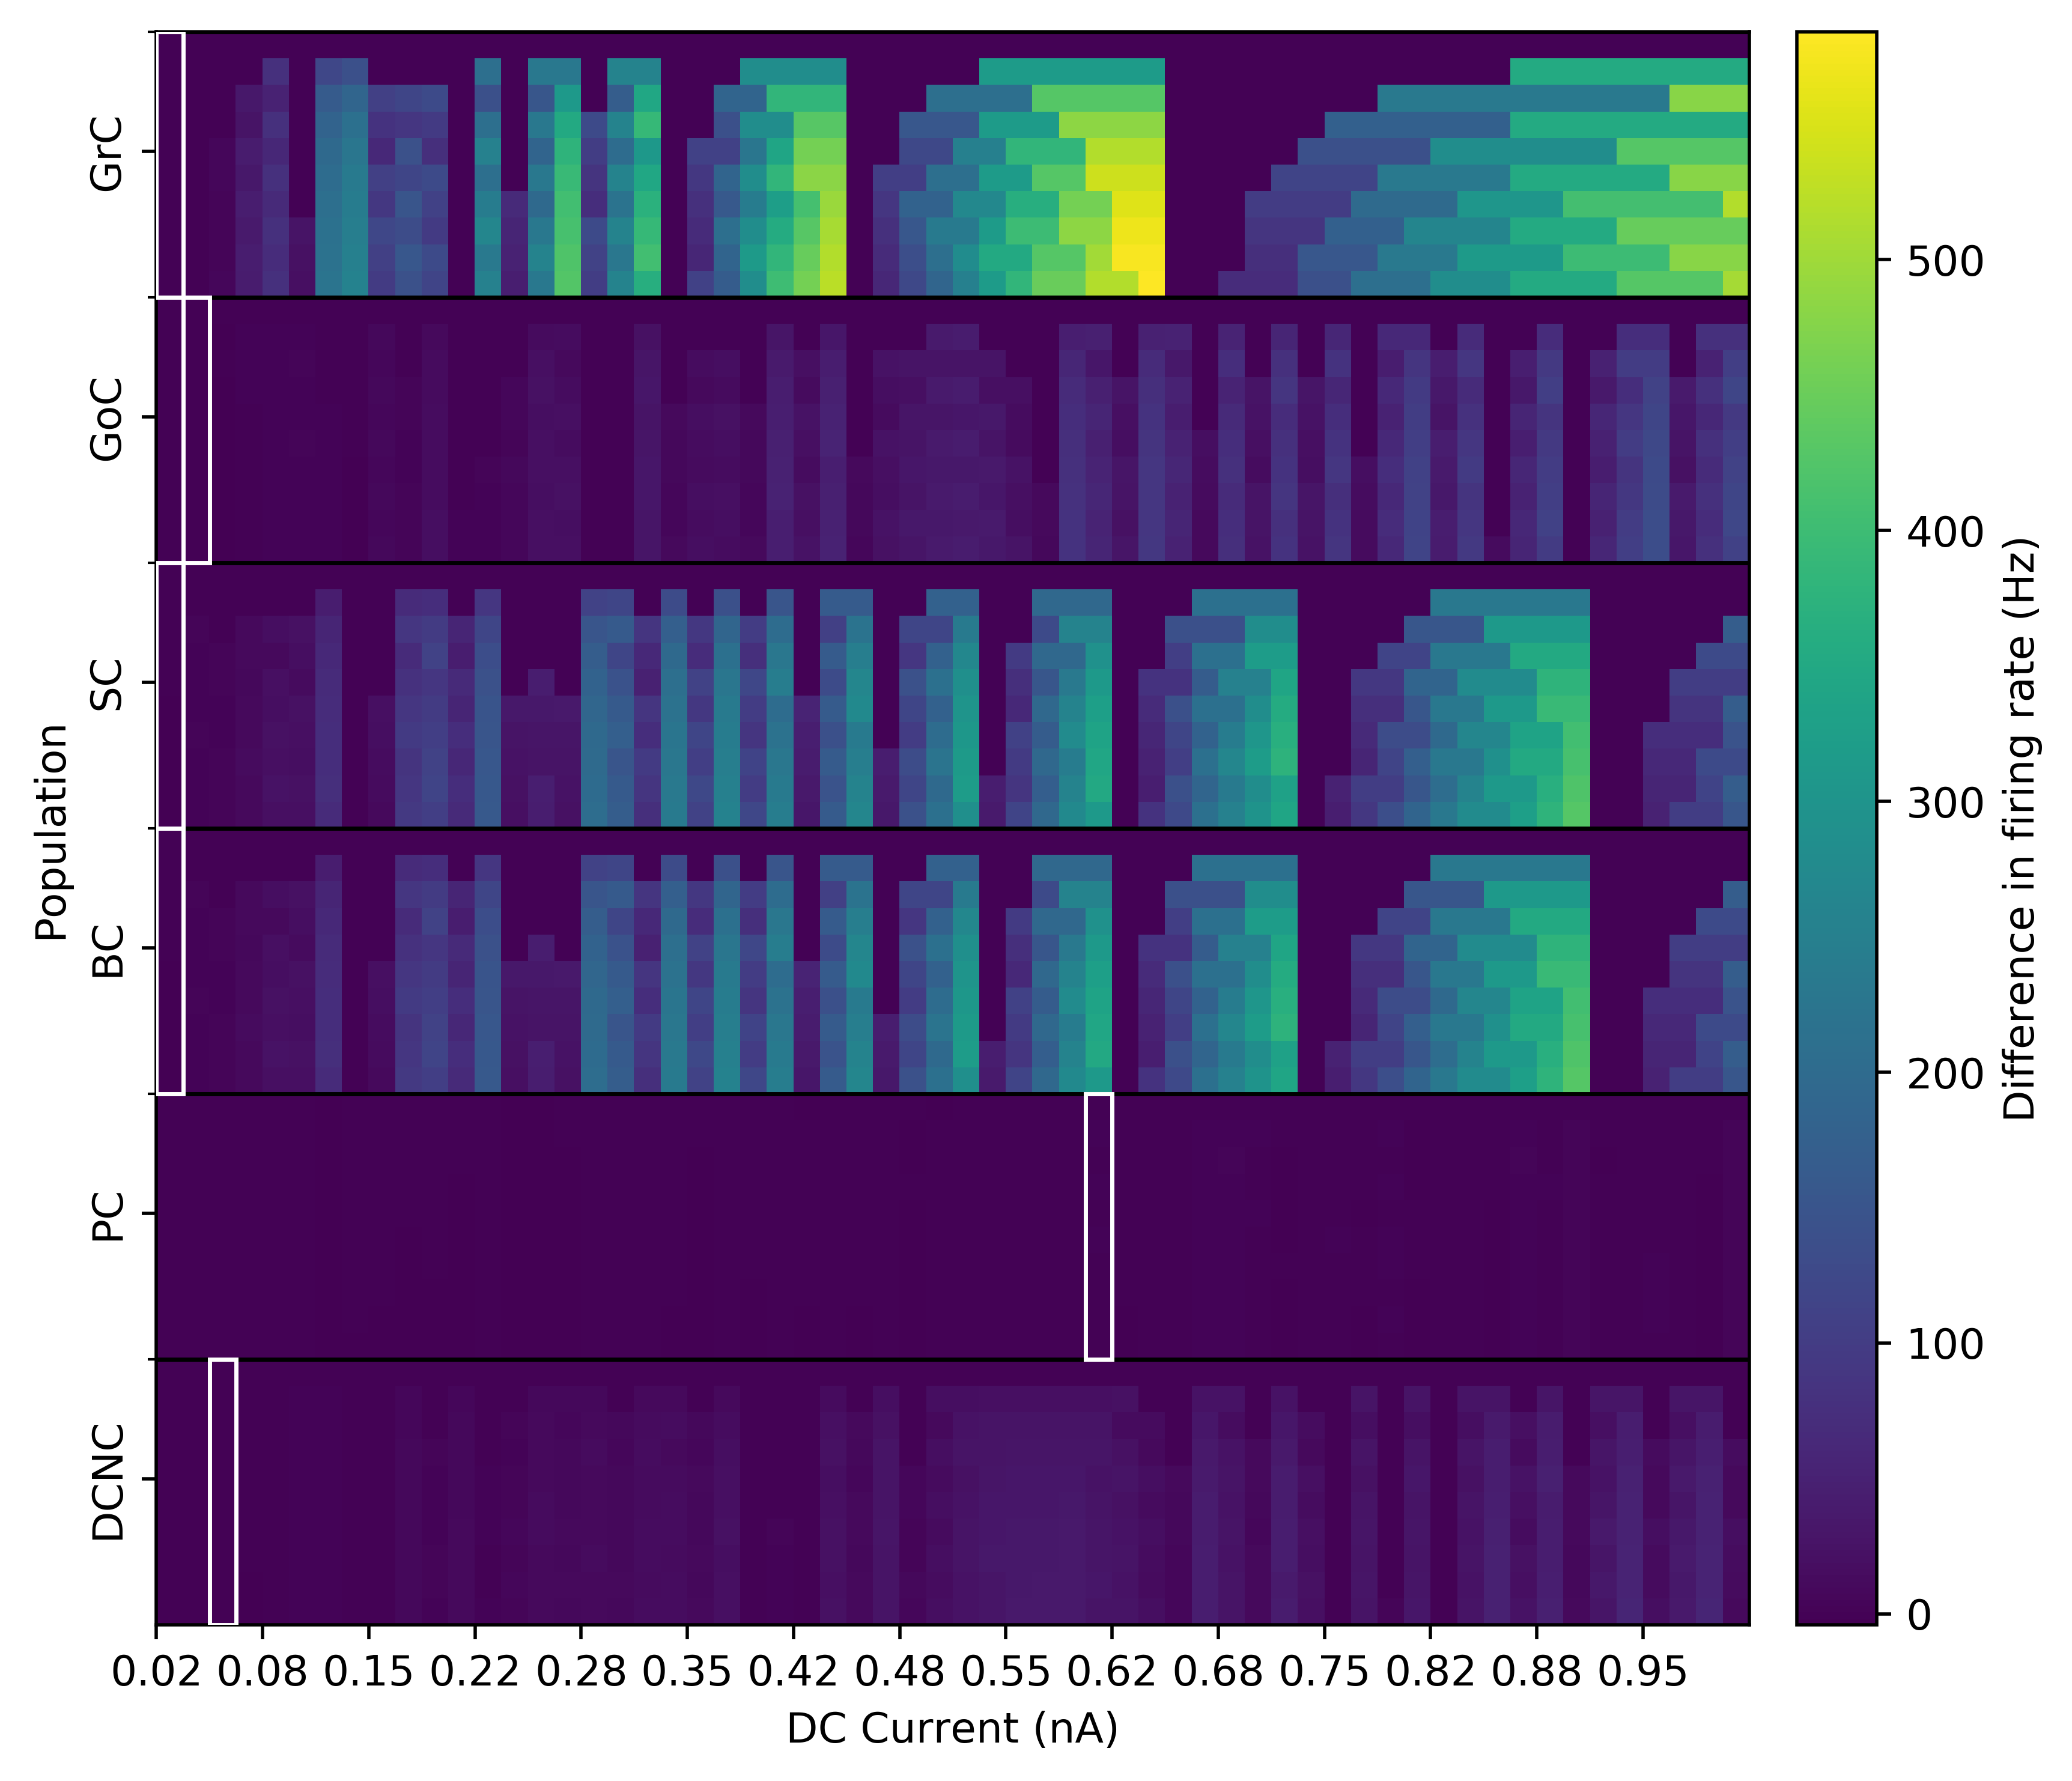

Plotting                                :figures/firing_rate_difference.png     
Plotting                                :figures/firing_rate_difference.pdf     


<Figure size 432x288 with 0 Axes>

In [928]:
plot_imshow_diff_map(diff_map, plot_order, dc_currents, subcycles, "DC Current (nA)", "Difference in firing rate (Hz)", "firing_rate_difference", fig_folder)

In [929]:
spike_lead_lag_map_10th

array([[ 0. ,  0. , -0.1, ..., -0.1, -0.1, -0.1],
       [ 0. ,  0. , -0.1, ..., -0.6, -0.6, -0.6],
       [ 0. ,  0. , -0.1, ..., -0.8, -0.8, -0.7],
       ...,
       [ 0. ,  2.8,  0.9, ..., -0.8, -1. , -0.3],
       [ 0. ,  3.1,  1. , ..., -0.7, -1. , -0.3],
       [ 0. ,  3.4,  1.1, ..., -0.7, -1. , -0.3]])

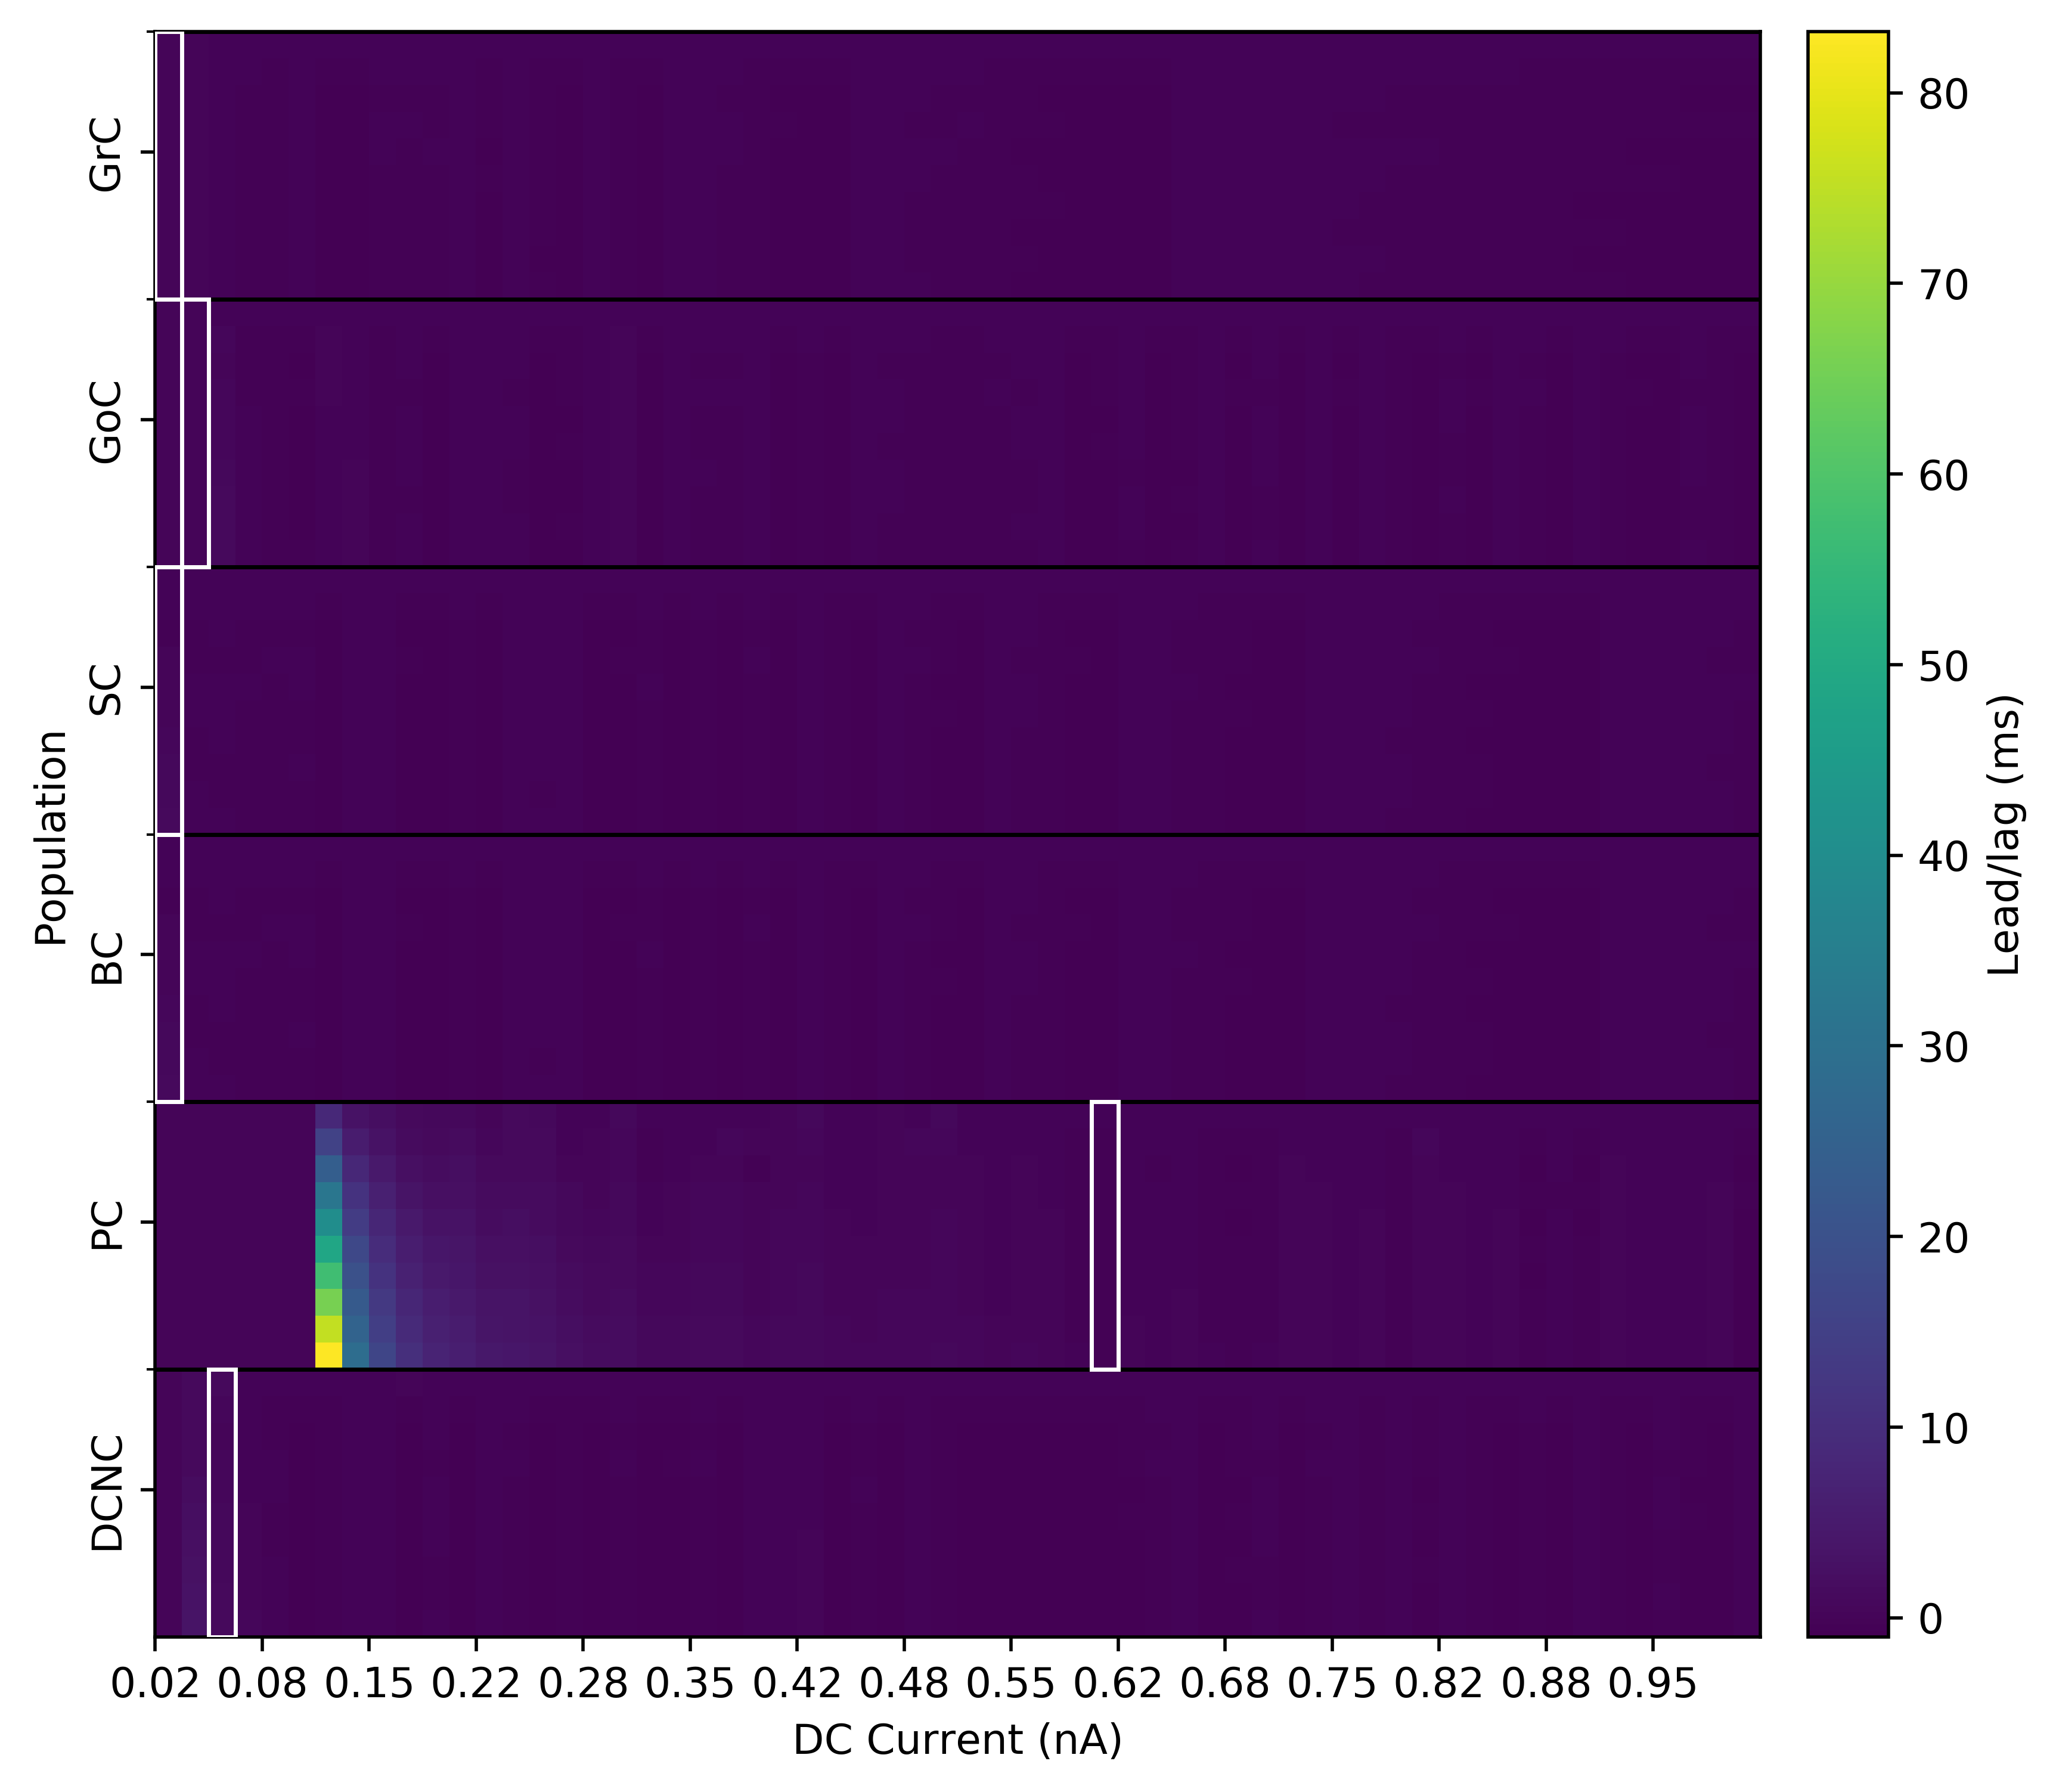

Plotting                                :figures/10th_spike_lead_lag_map.png    
Plotting                                :figures/10th_spike_lead_lag_map.pdf    


<Figure size 432x288 with 0 Axes>

In [930]:
plot_imshow_diff_map(spike_lead_lag_map_10th, plot_order, dc_currents, subcycles, "DC Current (nA)", "Lead/lag (ms)", "10th_spike_lead_lag_map", fig_folder,)

In [931]:
spike_lead_lag_map_100th

array([[ 0. ,  0. , -0.1, ..., -0.1, -0.1, -0.1],
       [ 0. ,  0. , -0.1, ..., -5.1, -5.1, -5.1],
       [ 0. ,  0. , -0.1, ..., -6.8, -6.8, -6.7],
       ...,
       [ 0. , 26.4,  8.8, ..., -6.4, -8.9, -2.6],
       [ 0. , 29.1, 10. , ..., -5.7, -9. , -2.3],
       [ 0. , 32.2, 11. , ..., -6.1, -9.1, -2.1]])

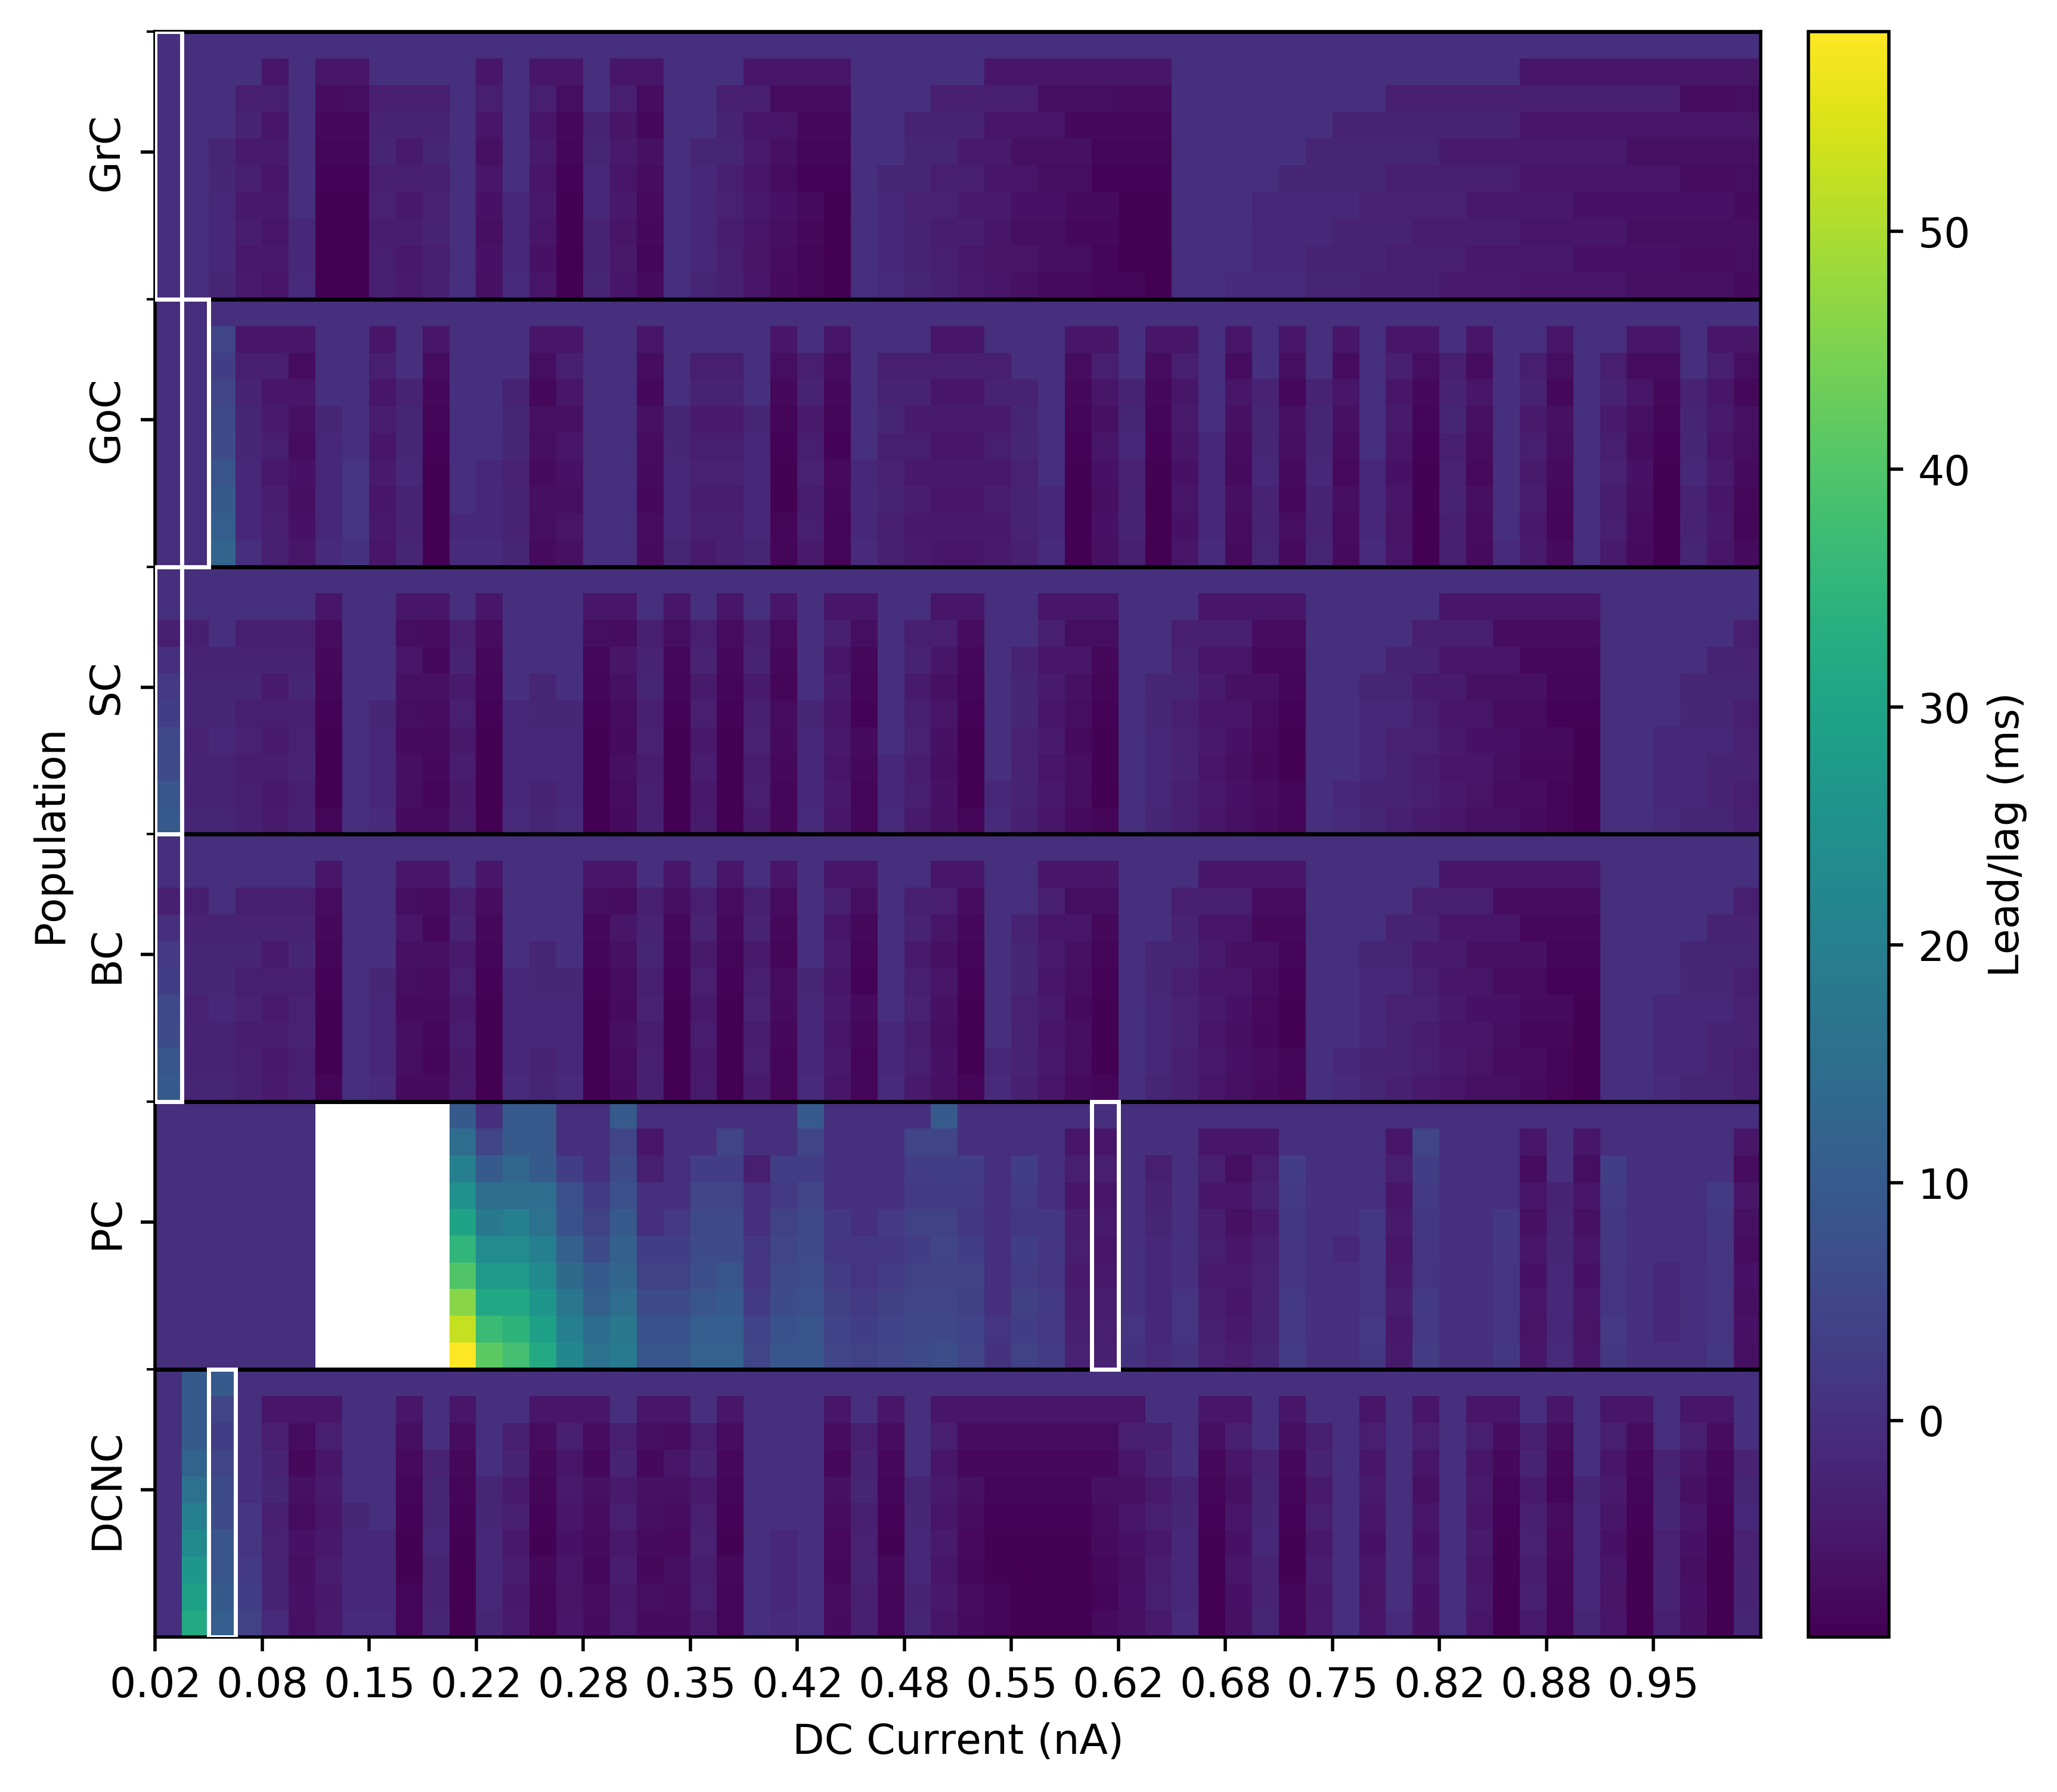

Plotting                                :figures/100th_spike_lead_lag_map.png   
Plotting                                :figures/100th_spike_lead_lag_map.pdf   


<Figure size 432x288 with 0 Axes>

In [932]:
plot_imshow_diff_map(spike_lead_lag_map_100th, plot_order, dc_currents, subcycles, "DC Current (nA)", "Lead/lag (ms)", "100th_spike_lead_lag_map", fig_folder,)

In [914]:
def plot_voltage(vs, baseline_vs, population, subcycles, dc_value, dc_currents=dc_currents, xlim=[0, 100]):
    n_plots = len(subcycles)
    dc_index = closest_ioffset_index(dc_currents, dc_value)
    plt.figure(figsize=(10, 5), dpi=300)
    plt.title("{} injected {:3.2f} nA".format(use_display_name(population), dc_currents[dc_index]))
    for index, sc in enumerate(subcycles):
        plt.plot(vs[sc][population][dc_index], 
                            color=viridis_cmap(index / (n_plots + 1)),
                 label="{} sub-cycles".format(sc) if sc != 1 else "{} sub-cycle".format(sc), 
                 alpha=.8
                )
    plt.plot(baseline_vs[1][population][dc_index], 
                            color="k",
                 label="Baseline",
                 linestyle=":",
                 alpha=.6
                )
    plt.ylabel("Membrane potential (mV)")
    plt.xlabel("Time step")
    plt.xlim(xlim)
    plt.legend(loc='best')

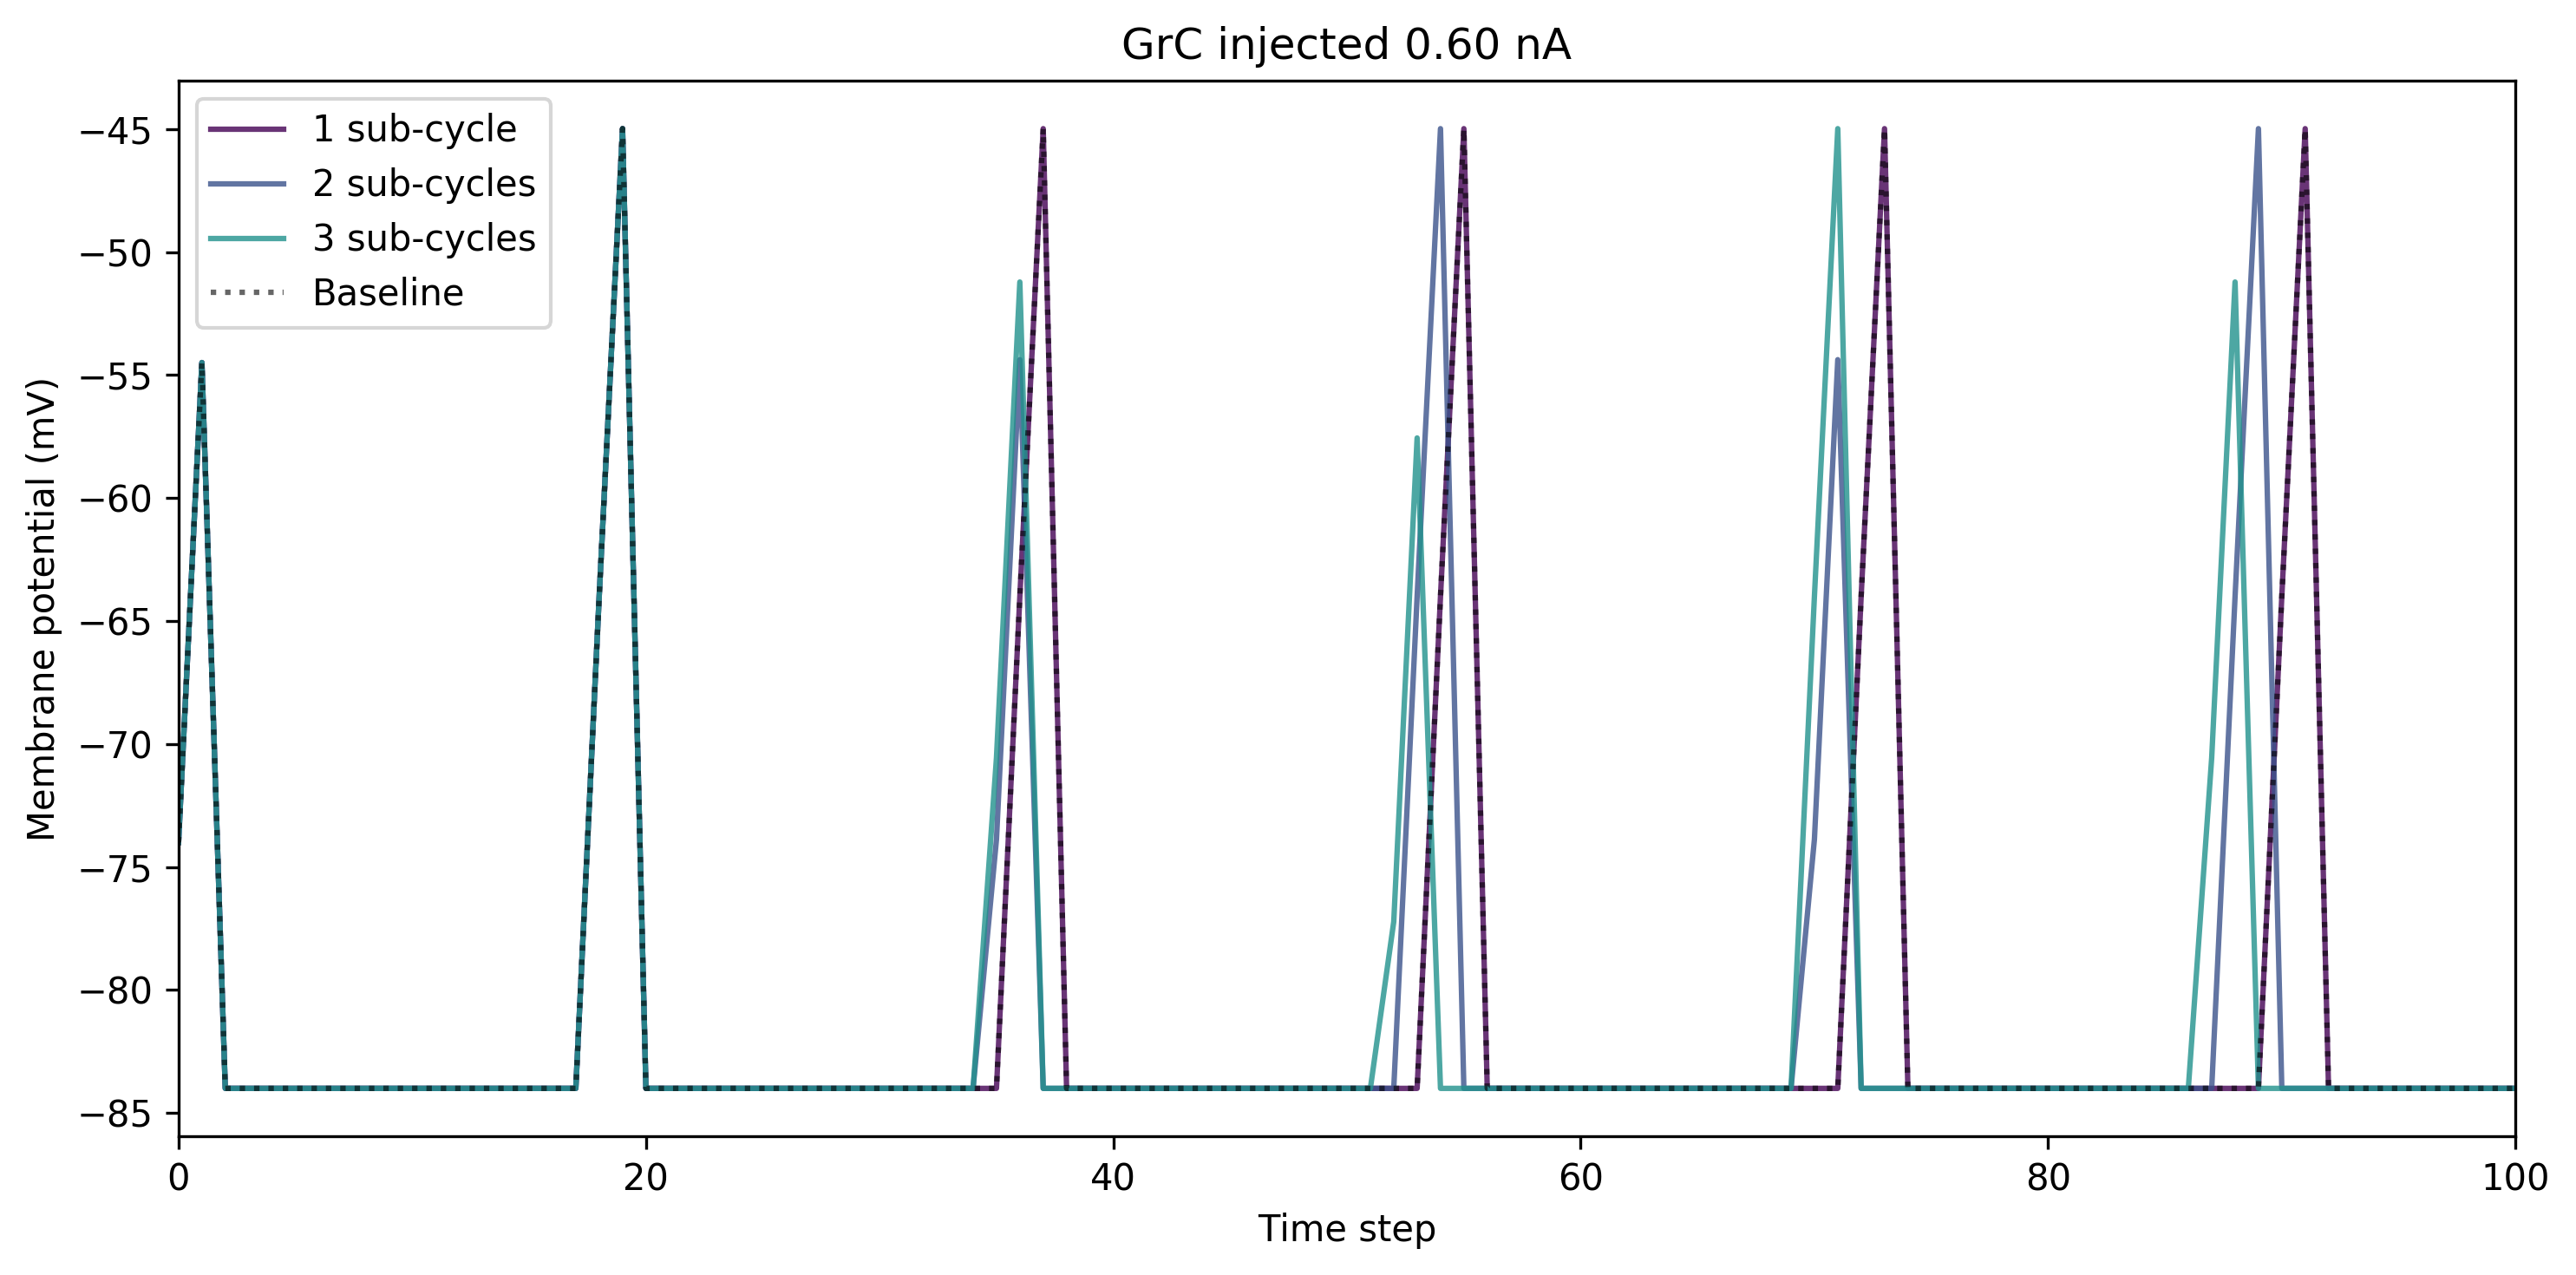

In [893]:
plot_voltage(vs, baseline_vs, population='granule', subcycles=[1,2,3], dc_value=0.6)

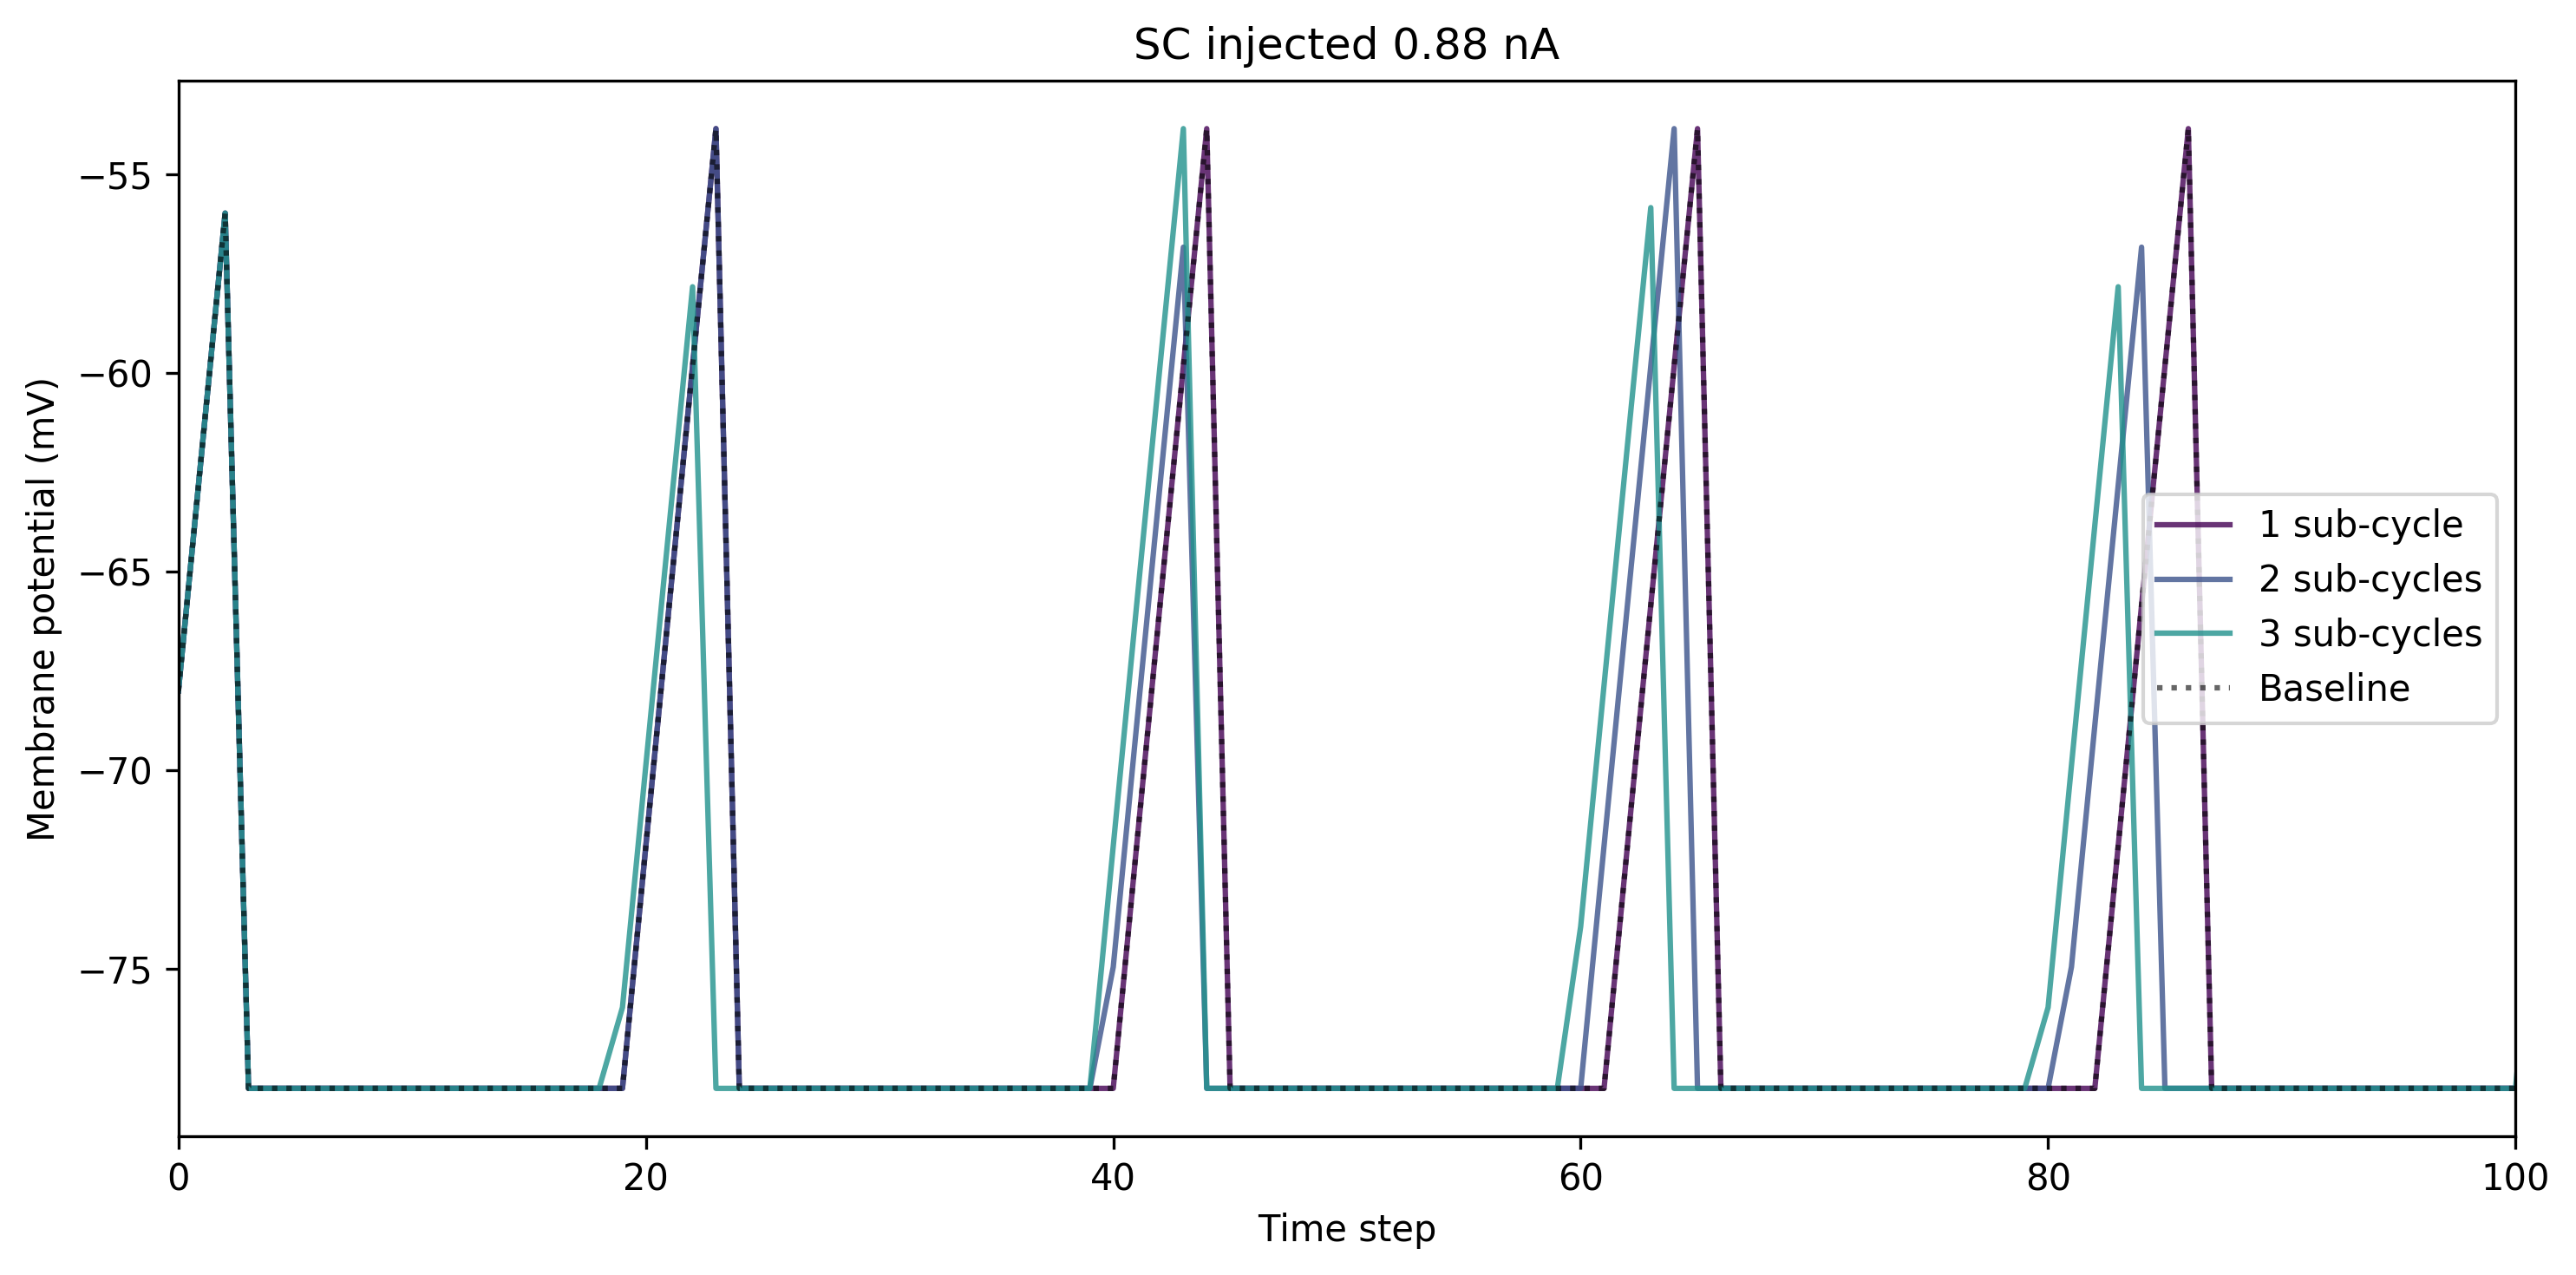

In [894]:
plot_voltage(vs, baseline_vs, population='stellate', subcycles=[1,2,3], dc_value=0.89)

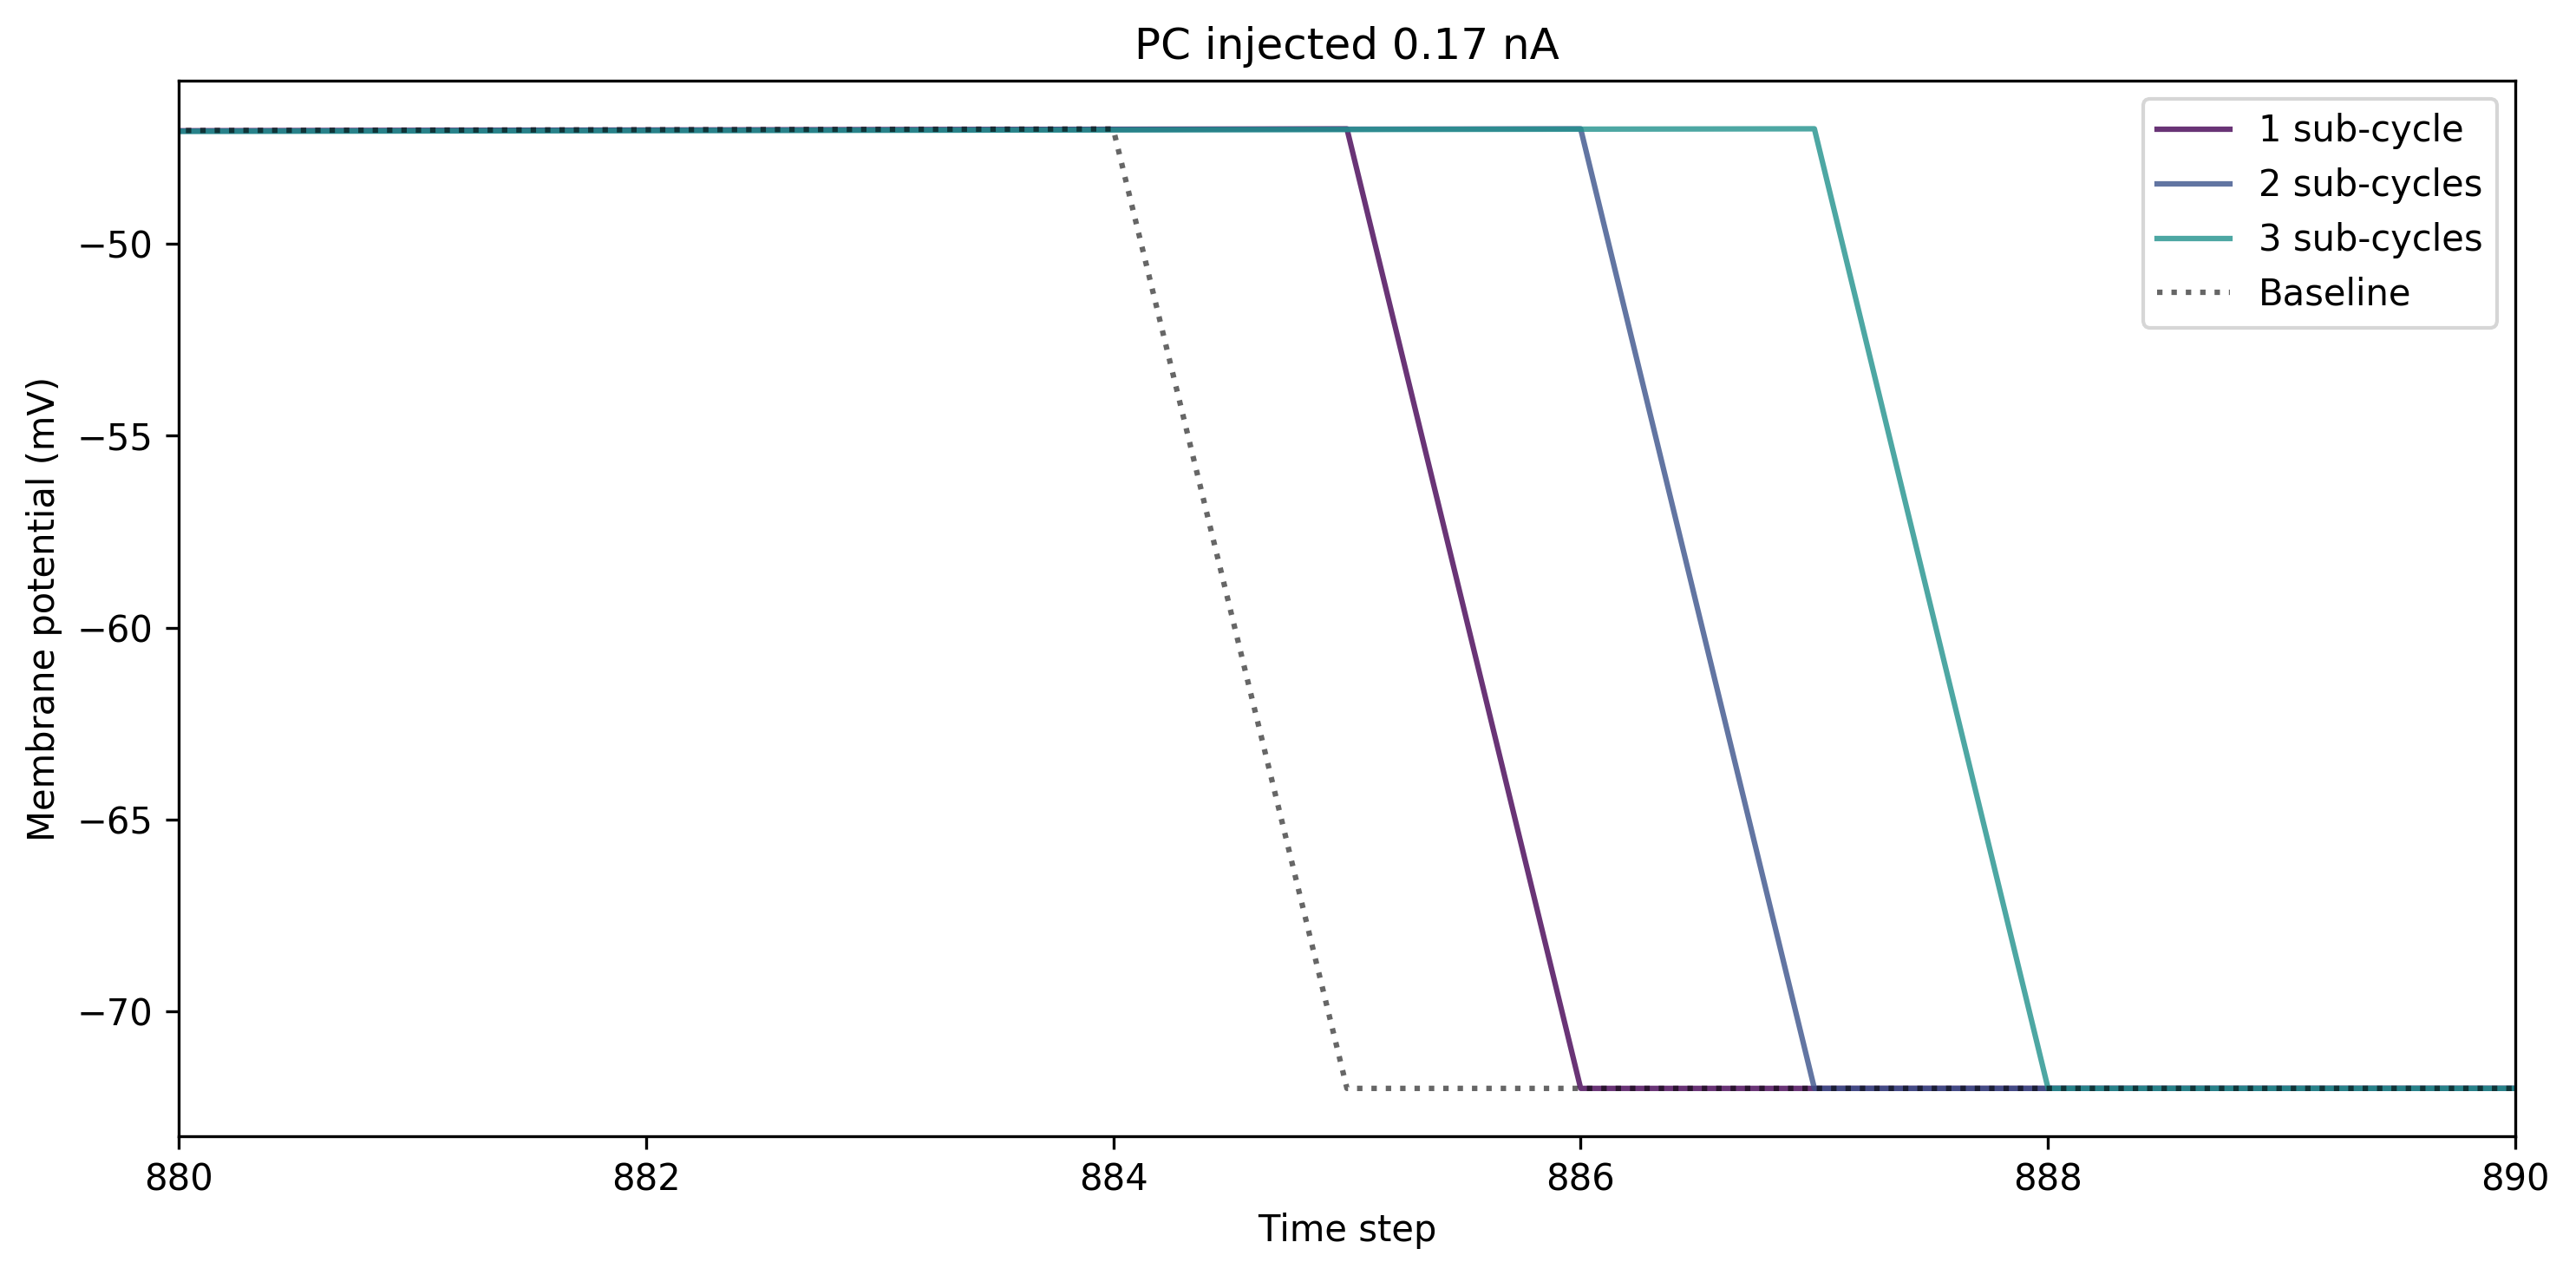

In [895]:
plot_voltage(vs, baseline_vs, population='purkinje', subcycles=[1,2,3], dc_value=.17, xlim=[880, 890])